# 프로젝트_주식 예측

## 목차
- 1. 프로젝트 개요
- 2. 시계열 데이터 준비
- 3. 각종 전처리 수행
    - (1) 결측치 처리
    - (2) 로그 변환
- 4. 시계열 안정성 분석
    - (1) 정성적 그래프 분석
    - (2) 정량적 Augmented Dicky-Fuller Test
    - (3) 시계열 분해(Time Series Decomposition)
    - (4) Residual 안정성 확인
- 5. 학습, 테스트 데이터셋 분리
- 6. 적정 ARIMA 모수 찾기
    - (1) ACF, PACF 그려보기 -> p.q 구하기
    - (2) 차분 안정성 확인 -> d 구하기 
- 7. ARIMA 모델 훈련과 테스트
    - (1) ARIMA 모델 빌드와 훈련
    - (2) 모델 테스트 및 플로팅
    - (3) 최종 예측 모델 정확도 측정(MAPE)
- 8. 다른 주식 종목 예측해 보기

## 1. 프로젝트 개요

- ARIMA를 통해 시계열 데이터 예측하는 과정 진행
- 실제 주식값 예측에 도전해 보기
- 데이터는 과거의 일자별 시세
- 대한미국 대장주 삼성전자에 대한 주식 시세 예측해 보기
![야후.png](./images/야후.png)

- 위 그림가 같이 [Yahoo Finance](https://finance.yahoo.com/)에서 오늘사용할 데이터셋 다운로드할 수 있음
- 클라우드 쥬피터에는 이미 데이터셋이 'stock_prediction/data'에 올라와 있음
- 아래 명령어로 '005930.KS.csv' 파일 존재 하는지 확인해 보기
![cmd2.png](./images/cmd2.png)
- 만약 해당 파일이 없다면 다음과 같이 실행
![cmd3.png](./images/cmd3.png)

## 2. 시계열 데이터 준비

- 컬럼 종류: Date, Open, High, Low, Close, Adj Close, Volume
- 날짜별로 시작가(Open), 최고가(High), 최저가(Low), 종가(Close), 수정종가(Adj Close), 거래량(Volume)이 저장되어 있는 것 확인할 수 있음
- 여기에서는 종가(Close)만 사용
- 주식 시장은 정해진 시간 동안만 거래가 가능
- 종가란 하루의 장이 마감하였을 때의 가격

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Time Series 생성
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/005930.KS.csv'
df = pd.read_csv(dataset_filepath, index_col = 'Date', parse_dates = True)
ts = df['Close']

ts.head()

Date
2020-05-18    48800.0
2020-05-19    50300.0
2020-05-20    50000.0
2020-05-21    49950.0
2020-05-22    48750.0
Name: Close, dtype: float64

## 3. 각종 전처리 수행
- (1) 결측치 처리
- (2) 로그 변환

### (1) 결측치 처리

- 다행히 이 데이터에는 결측치가 없음
- 하지만 혹시 결측치가 있다면 조치가 필요
- NaN이 들어있는 데이터는 통계분석 시에 많은 오류를 일으킨뿐더라 분석결과에도 악영향 미칠 것
- 만약 결측치가 있다면, 2가지 방법으로 결측치 처리해 줄 수 있음
    - 1. 결측치가 있는 데이터를 모두 삭제(drop)
    - 2. 결측치 양옆의 값들을 이용해서 적절히 보간(interpolate)하여 대입
        - ex) 2와 4사이 데이터가 NaN이라면 이 값을 3으로 채우는 방식
- 이번 경우라면 시간을 index로 가지는 시계열 데이터이므로 삭제하는 것보다는 '보간'하는 방법을 선택
- Pandas에서 결측치 보간을 처리하는 메소드는 다음과 같음
- 상세한 설명은 [아티클](https://rfriend.tistory.com/264)을 참고

In [2]:
ts = ts.interpolate(method = 'time')
# Time Series에서 결측치가 있는 부분만 Series로 출력
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

### (2) 로그 변환

- 가장 먼저 고려해 볼 수 있는 것은 시간 추이에 따라 분산이 점점 커지고 있다는 점
- 시계열이 이런 특성을 보일 경우에는 로그함수로 변환을 해주는 것이 도움이 됨

In [3]:
ts_log = np.log(ts)

## 4. 시계열 안정성 분석
- (1) 정성적 그래프 분석
- (2) 정량적 Augmented Dicky-Fuller Test
- (3) 시계열 분해(Time Series Decomposition)
- (4) Residual 안정성 확인

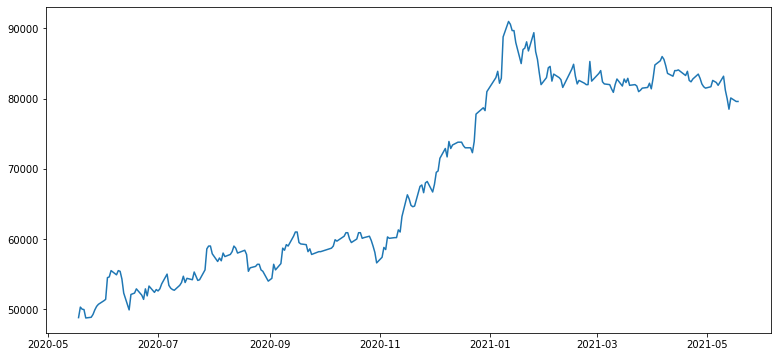

In [6]:
from matplotlib.pylab import rcParams

# matlab 차트의 기본 크기를 13, 6으로 지정
rcParams['figure.figsize'] = 13, 6

# 시계열(time series) 데이터를 차트로 그려보기
plt.plot(ts)

- 시간 추이에 따라 일정한 평균, 분산, 자기공분산의 패턴이 나타나는 것 같은가?
- 시계열 데이터의 통계적 특성을 좀 더 명료하게 시각화해 보기
- 아래는 일정 시간 내 '구간 통계치(Rolling Statistics)'를 시각화해 보는 함수
- '현재 타임스텝'부터 'window에 주어진 타임스텝 이전' 사이
    - 1. 구간의 평균(rolling mean, '이동평균')과
    - 2. 표준편차(rolling std, '이동표준편차')를
- 원본 시계열과 함께 '시각화'해보면 좀 더 뚜렷한 경향성 확인할 수 있음
- [이동평균이란?](https://www.econowide.com/3544)

In [8]:
def plot_rolling_statistics(timeseries, window = 12):
    
    # 이동평균 시계열
    rolmean = timeseries.rolling(window = window).mean()
    # 이동표준편차 시계열
    rolstd = timeseries.rolling(window = window).std()
    
    # 원본시계열, 이동평균, 이동표준편차를 plot로 시각화
    orig = plt.plot(timeseries, color = 'blue', label = 'Original')
    mean = plt.plot(rolmean, color = 'red', label = 'Rolling Mean')
    std = plt.plot(rolstd, color = 'black', label = 'Rolling Std')
    plt.legend(loc = 'best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block = False)
    
print('슝=3')

슝=3


### (1) 정성적 그래프 분석

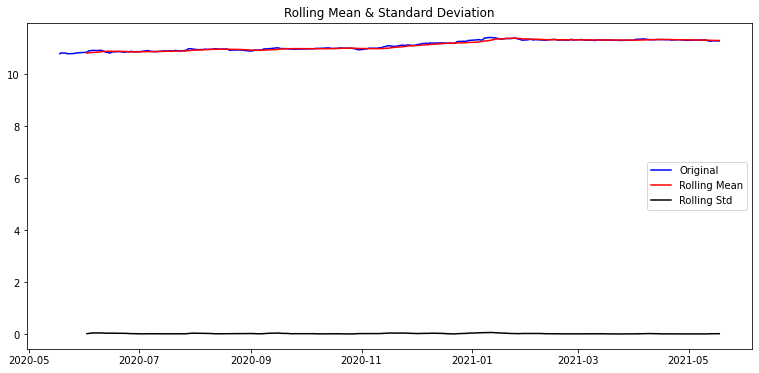

In [9]:
plot_rolling_statistics(ts_log, window = 12)

### (2) 정량적 Augmented Dicky-Fuller Test

#### Augmented Dickey-Fuller Test(ADF Test)
- 시계열 데이터의 안정성(stationary)을 테스트하는 통계적 방법 소개
- 이 테스트는
> 1. '주어진 시계열 데이터가 안정적이지 않다'라는 '귀무가설(Null Hyphothesis)'를 세운 후, <br>
> 2. 통계적 가설 검정 과정을 통해 이 귀무가설이 기각될 경우에 <br>
> 3. '이 시계열 데이터가 안정적이다'라는 '대립가설(Alternative Hypothesis)'을 **채택**한다는 내용

- 시계열 분석은 탄탄한 통계학적 기반에 입각한 만큼 제대로 이해하기 위해서는 전반적인 훈련 필요
- ADF Test의 세부 알고리즘은 우선 상랙하고, 'statsmodels' 패키지에서 제공하는 'adfuller' 메소드를 이용해 손쉽게 ADF Test 결과 이용할 것
- 세부 알고리즘을 좀더 파악하고 싶다면 Unit Root Test의 개념으로부터 ADF Test에 대한 설명으로 이어지는 [이 글](https://www.machinelearningplus.com/time-series/augmented-dickey-fuller-test/) 추천
- 통계적 가설 검정의 기본 개념 이루는 'p-values' 등의 용어에 대해서는 1번쯤 짚고 넘어가는 것이 이후 과정의 이해를 도울 것이라고 판단
- [유의확률 - 위키백과](https://ko.wikipedia.org/wiki/%EC%9C%A0%EC%9D%98_%ED%99%95%EB%A5%A0)
- [P-value(유의확률)의 개념](https://m.blog.naver.com/baedical/10109291879)

#### statsmodels 패키지와 adfuller 메소드
- statsmodels 패키지는 R에서 제공하는 통계검정, 시계열분석 등의 기능을 파이썬에서도 이용할 수 있도록 하는 강력한 통계 패키지
- 이번 노드에서는 statsmodels 패키지의 기능을 자주 활용하게 될 것
- 아래는 'statsmodels' 패키지에서 제공하는 'adfuller' 메소드를 이용해 **주어진 timeseries에 대한 Augmented Dickey-Fuller Test를 수행하는 코드**

In [11]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출
    dftest = adfuller(timeseries, autolag = 'AIC')
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index = ['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
print('슝=3')

슝=3


In [12]:
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


### (3) 시계열 분해(Time Series Decomposition)

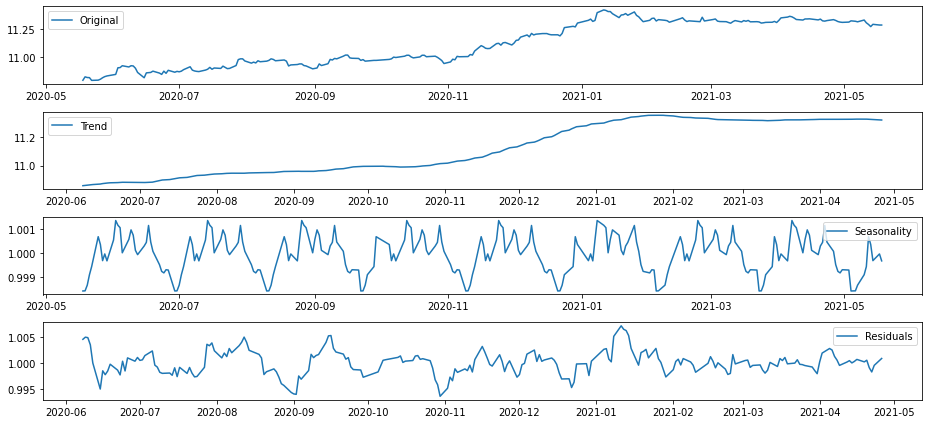

In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

### (4) Residual 안정성 확인

In [14]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.187586e+00
p-value                        6.234854e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.100000e+02
Critical Value (1%)           -3.461879e+00
Critical Value (5%)           -2.875404e+00
Critical Value (10%)          -2.574159e+00
dtype: float64


## 5. 학습, 테스트 데이터셋  생성

- 학습, 테스트 데이터셋 분리

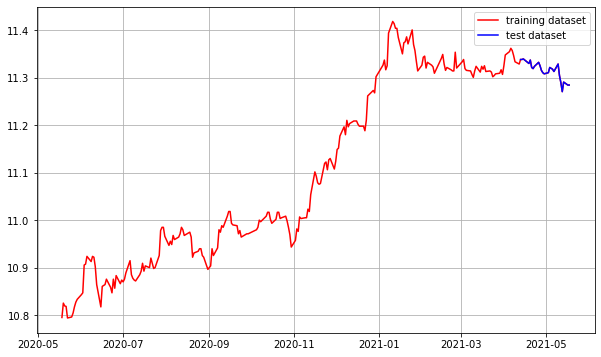

In [15]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

## 6. 적정 ARIMA 모수 찾기
- (1) ACF, PACF 그려보기 -> p.q 구하기
- (2) 차분 안정성 확인 -> d 구하기

### (1) ACF PACF 그려보기 -> p, q 구하기

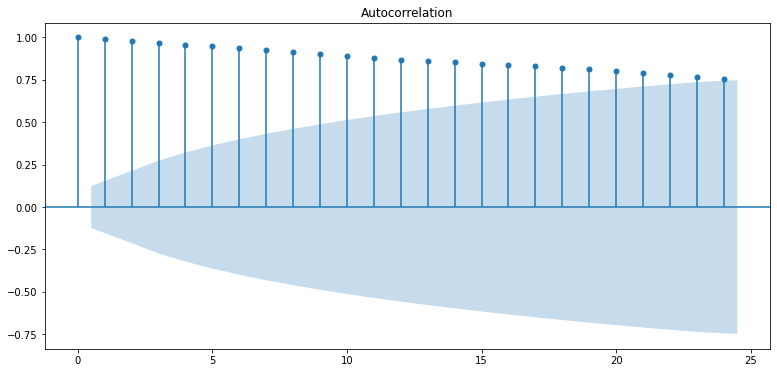

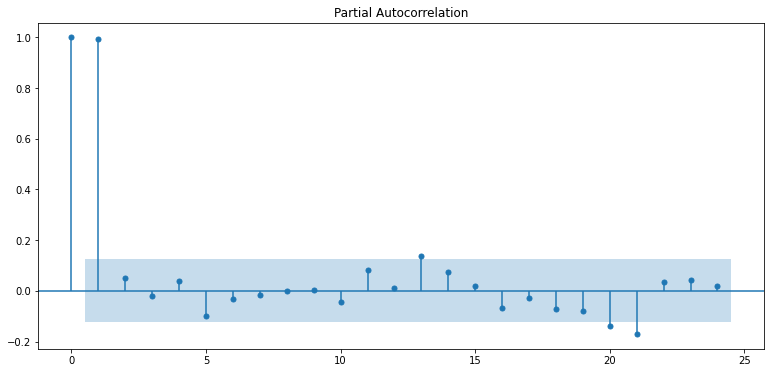

In [16]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ACF : Autocorrelation 그래프 그리기
plot_acf(ts_log)   
# PACF : Partial Autocorrelation 그래프 그리기
plot_pacf(ts_log)  
plt.show()

### (2) 차분 안정성 확인 -> d 구하기

Results of Dickey-Fuller Test:
Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -1.029320e+01
p-value                        3.525823e-18
#Lags Used                     7.000000e+00
Number of Observations Used    2.400000e+02
Critical Value (1%)           -3.457894e+00
Critical Value (5%)           -2.873659e+00
Critical Value (10%)          -2.573229e+00
dtype: float64


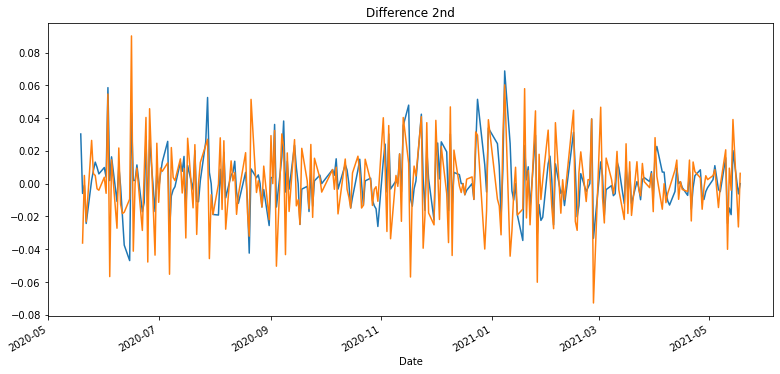

In [17]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

## 7. ARIMA 모델 훈련과 테스트
- (1) ARIMA 모델 빌드와 훈련
- (2) 모델 테스트 및 플로팅
- (3) 최종 예측 모델 정확도 측정(MAPE)

### (1) ARIMA 모델 빌드와 훈련

In [18]:
from statsmodels.tsa.arima_model import ARIMA

# Build and Train  Model
model = ARIMA(train_data, order=(1, 1, 0))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  224
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 585.396
Method:                       css-mle   S.D. of innovations              0.018
Date:                Tue, 07 Sep 2021   AIC                          -1164.792
Time:                        08:40:53   BIC                          -1154.557
Sample:                             1   HQIC                         -1160.661
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0024      0.001      1.978      0.048    2.17e-05       0.005
ar.L1.D.Close     0.0168      0.067      0.250      0.803      -0.115       0.148
                                    Root

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency informa

### (2) 모델 테스트 및 플로팅

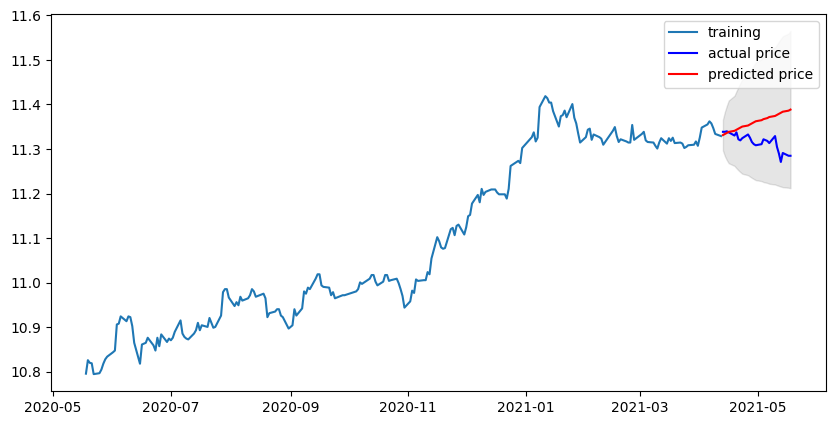

In [19]:
# Forecast : 결과가 fc에 담김 
# 95% conf
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  

# Make as pandas series

# 예측결과
fc_series = pd.Series(fc, index=test_data.index)   
# 예측결과의 하한 바운드
lower_series = pd.Series(conf[:, 0], index=test_data.index)
# 예측결과의 상한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

### (3) 최종 예측 모델 정확도 측정(MAPE)

In [20]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  22087366.126154922
MAE:  3791.3511527213127
RMSE:  4699.719792301976
MAPE: 4.68%


## 8. 다른 주식 종목 예측해 보기
- TSLA.csv 주식 데이터 활용해 위의 과정 반복해 보기

### 테슬라 주식 데이터
- 2020.09.07 ~ 2021.09.07 1년간의 데이터
- 컬럼 종류: Date, Open, High, Low, Close, Adj Close, Volume
- 날짜별로 시작가(Open), 최고가(High), 최저가(Low), 종가(Close), 수정종가(Adj Close), 거래량(Volume)이 저장되어 있는 것 확인할 수 있음
- 여기에서는 종가(Close)만 사용
- 주식 시장은 정해진 시간 동안만 거래가 가능
- 종가란 하루의 장이 마감하였을 때의 가격

In [34]:
dataset_filepath = os.getenv('HOME') + '/aiffel/Exploration/Exploration_14/TSLA.csv'
df = pd.read_csv(dataset_filepath, index_col = 'Date', parse_dates = True)
ts = df['Close']

ts.head()

Date
2020-09-08    330.209991
2020-09-09    366.279999
2020-09-10    371.339996
2020-09-11    372.720001
2020-09-14    419.619995
Name: Close, dtype: float64

- 시간 컬럼이 index가 되었지만 아직도 type은 DataFrame으로 나옴
- 우리가 찾는 시계열은 바로 여기 있음

#### 결측치 처리

In [35]:
ts = ts.interpolate(method = 'time')
# Time Series에서 결측치가 있는 부분만 Series로 출력
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

#### 로그 변환

In [36]:
ts_log = np.log(ts)

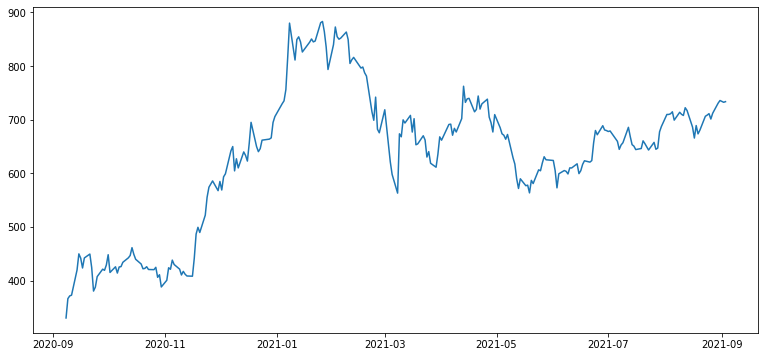

In [37]:
from matplotlib.pylab import rcParams

# matlab 차트의 기본 크기를 13, 6으로 지정
rcParams['figure.figsize'] = 13, 6

# 시계열(time series) 데이터를 차트로 그려보기
plt.plot(ts)

In [38]:
def plot_rolling_statistics(timeseries, window = 12):
    
    # 이동평균 시계열
    rolmean = timeseries.rolling(window = window).mean()
    # 이동표준편차 시계열
    rolstd = timeseries.rolling(window = window).std()
    
    # 원본시계열, 이동평균, 이동표준편차를 plot로 시각화
    orig = plt.plot(timeseries, color = 'blue', label = 'Original')
    mean = plt.plot(rolmean, color = 'red', label = 'Rolling Mean')
    std = plt.plot(rolstd, color = 'black', label = 'Rolling Std')
    plt.legend(loc = 'best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block = False)
    
print('슝=3')

슝=3


#### 정성적 그래프 분석

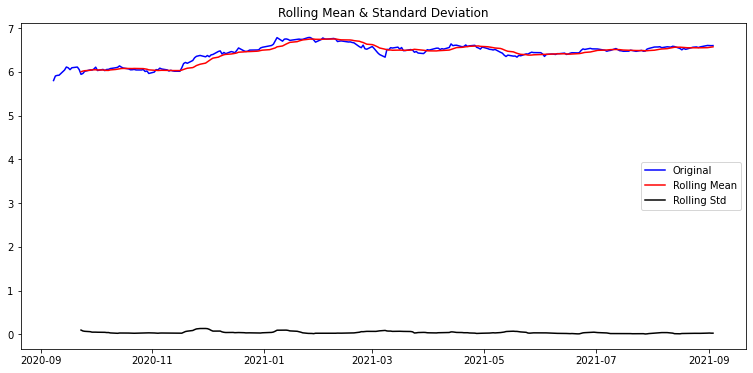

In [39]:
plot_rolling_statistics(ts_log, window = 12)

#### 정량적 Augmented Dicky-Fuller Test

In [40]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출
    dftest = adfuller(timeseries, autolag = 'AIC')
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index = ['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
print('슝=3')

슝=3


In [41]:
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -2.710861
p-value                          0.072178
#Lags Used                       0.000000
Number of Observations Used    250.000000
Critical Value (1%)             -3.456781
Critical Value (5%)             -2.873172
Critical Value (10%)            -2.572969
dtype: float64


#### 시계열 분해

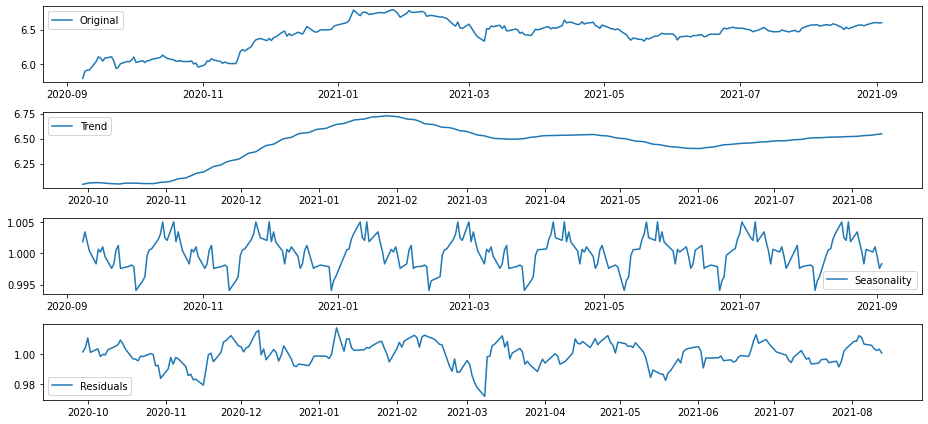

In [42]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

#### Residual 안정성 확인

In [43]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -5.105330
p-value                          0.000014
#Lags Used                       0.000000
Number of Observations Used    220.000000
Critical Value (1%)             -3.460428
Critical Value (5%)             -2.874769
Critical Value (10%)            -2.573821
dtype: float64


#### 학습, 테스트 데이터셋 분리

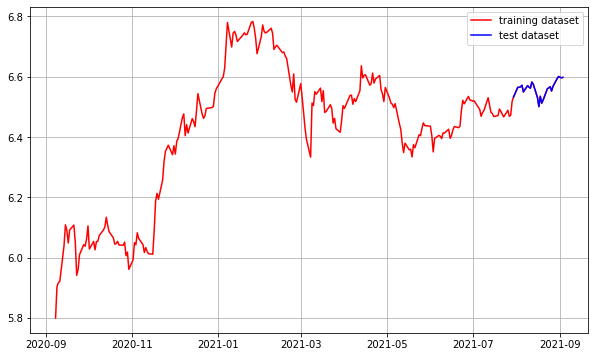

In [44]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

#### ACF PACF 그려보기 -> p, q 구하기

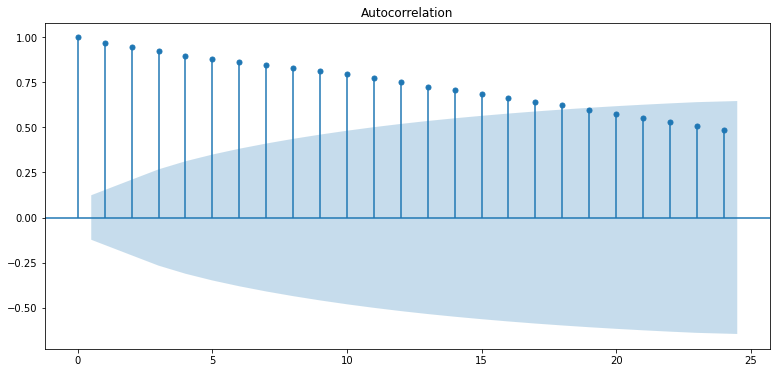

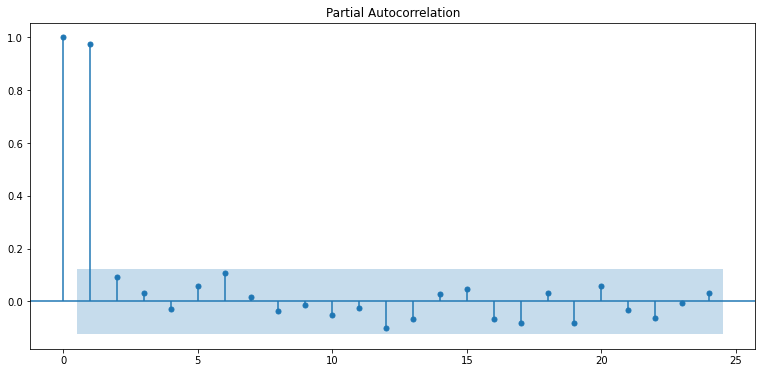

In [45]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ACF : Autocorrelation 그래프 그리기
plot_acf(ts_log)   
# PACF : Partial Autocorrelation 그래프 그리기
plot_pacf(ts_log)  
plt.show()

#### 차분 안정성 확인 -> d 구하기

Results of Dickey-Fuller Test:
Test Statistic                -1.637067e+01
p-value                        2.812385e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.490000e+02
Critical Value (1%)           -3.456888e+00
Critical Value (5%)           -2.873219e+00
Critical Value (10%)          -2.572994e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -1.102374e+01
p-value                        5.898900e-20
#Lags Used                     7.000000e+00
Number of Observations Used    2.410000e+02
Critical Value (1%)           -3.457779e+00
Critical Value (5%)           -2.873609e+00
Critical Value (10%)          -2.573202e+00
dtype: float64


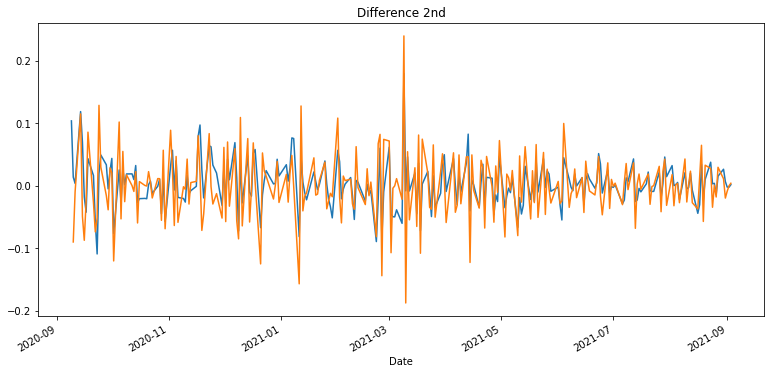

In [46]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

#### ARIMA 모델 빌드와 훈련

In [47]:
from statsmodels.tsa.arima_model import ARIMA

# Build and Train  Model
model = ARIMA(train_data, order=(1, 1, 0))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  224
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 414.678
Method:                       css-mle   S.D. of innovations              0.038
Date:                Tue, 07 Sep 2021   AIC                           -823.357
Time:                        13:50:05   BIC                           -813.122
Sample:                             1   HQIC                          -819.225
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0032      0.002      1.291      0.197      -0.002       0.008
ar.L1.D.Close    -0.0279      0.068     -0.410      0.681      -0.161       0.105
                                    Root

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency informa

#### 모델 테스트 및 플로팅

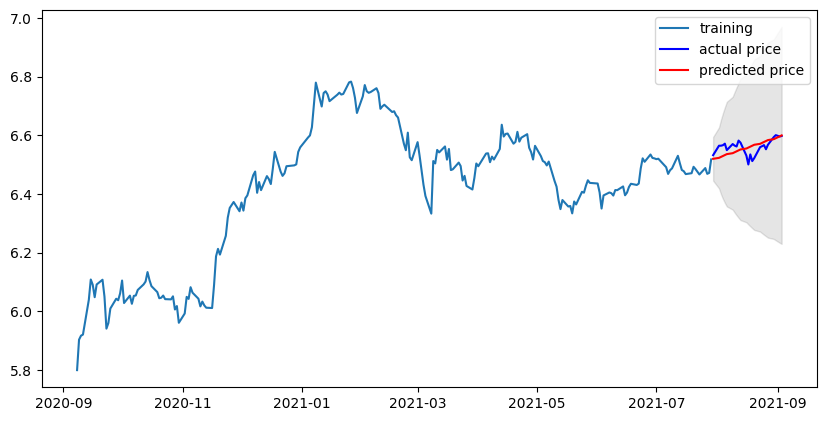

In [48]:
# Forecast : 결과가 fc에 담김 
# 95% conf
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  

# Make as pandas series

# 예측결과
fc_series = pd.Series(fc, index=test_data.index)   
# 예측결과의 하한 바운드
lower_series = pd.Series(conf[:, 0], index=test_data.index)
# 예측결과의 상한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

#### 최종 예측 모델 정확도 측정(MAPE)

In [49]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  389.4746714952593
MAE:  16.620260166409174
RMSE:  19.735112654739503
MAPE: 2.38%
